In [1]:
import pandas as pd

# Remplacez 'nom_du_fichier.csv' par le chemin de votre fichier CSV
data = pd.read_csv("cities_africa.csv", sep = ";")
data_clean = data[['Name', 'Population', 'Coordinates']]  # Remplacez 'colonne1', 'colonne2', 'colonne3' par les noms de vos colonnes
nouvelles_colonnes = data['Coordinates'].str.split(',', expand=True)

# Renommer les nouvelles colonnes
nouvelles_colonnes.columns = ['lon', 'lat']

# Concaténer les nouvelles colonnes avec le DataFrame d'origine en supprimant la colonne d'origine
data_clean = pd.concat([data_clean, nouvelles_colonnes], axis=1).drop(columns=['Coordinates'])


import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import numba


yp = data_clean["lon"] 
yp = np.array(yp)
yp = yp.astype(float)
xp = data_clean["lat"]  
xp = np.array(xp)
xp = xp.astype(float)
"""population = data_clean["Population"]
population = np.array(population)
population = population.astype(float)"""
population = np.random.randint(1, 501, size=len(xp))

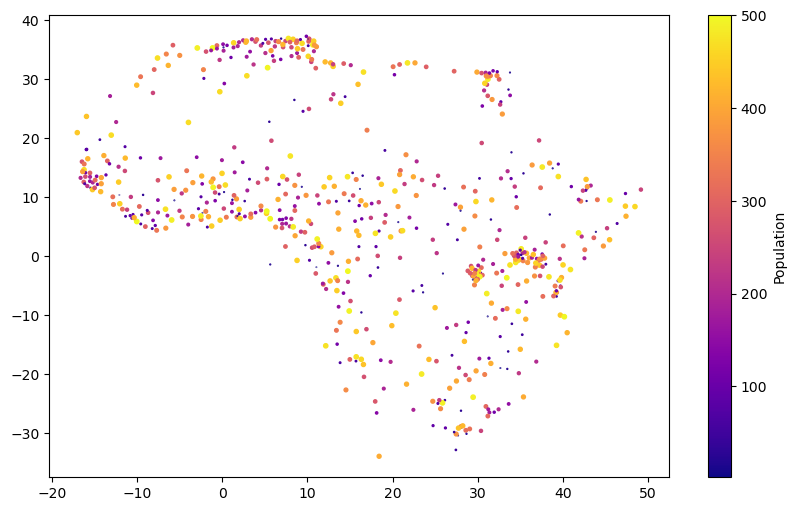

In [2]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)




# Déterminez la taille des points en fonction de la densité de population
# Vous pouvez ajuster le facteur multiplicatif selon vos préférences
size = population*0.02


# Affichage des densités de population en tant que points colorés
sc = ax.scatter(xp, yp, c=population, cmap='plasma',
                s=size)
plt.colorbar(sc, label='Population')

In [8]:
Hs = 1
N = 20
Is = 10000
Imin = 1
IminSol = 1e-3
eps = 1e-1
p = 300


xt = np.linspace(-20, 50, 250)
yt = np.linspace(-40, 40, 250)
Xt, Yt = np.meshgrid(xt, yt)

In [9]:
@numba.jit(nopython = True)
def sigmoid(x, center = 0, M = 100) : 
    return 1/(1+np.exp(-M*(x-center)))

@numba.jit(nopython = True)
def pyth(x1, x2, y1, y2) : 
    return (x2-x1)**2 + (y2-y1)**2

In [10]:

        
    
    

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(N) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)

def objectif(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq) * population[j]
            
        somme += sumj
        
    return -somme

@numba.jit(nopython = True, parallel = True)
def contrainte2(x) : 
    somme = 0
    for j in numba.prange(p) : 
        for k in numba.prange(p) : 
            sum_point = 0
            for i in numba.prange(N) : 
                x_posit = -20+(j/p)*70
                y_posit = -40+(k/p)*80
                di_sq = pyth(x_posit, x[2*i], y_posit, x[2*i+1]) + Hs**2

                sum_point += Is/(di_sq)
            if sum_point >= IminSol : 
                somme+=1
  
    return somme/(p**2)
    

In [11]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.8, 1)
#myc2 = NonlinearConstraint(contrainte2, 0.8, 1)
contraintes = [myc1]
x0 = [0.0] * 2*N
for i in range(N) : 
    x0[2*i] = np.random.uniform(-20, 50)
    x0[2*i+1] = np.random.uniform(-40, 40)
t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))
#print("Valeur de la contrainte 2 : ", contrainte2(resultat.x))

temps :  45.21242308616638
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -343763057.8857494
       x: [ 7.525e+00  5.387e+00 ... -2.291e+00  6.749e+00]
    nfev: 1000
   maxcv: 0.0
Résultat de l'optimisation: -343763057.8857494
Valeurs optimales des variables: [  7.52472254   5.38665379  15.83537434 -12.72514448  34.96832583
  -0.40498153   7.33802002  13.10455227   3.23622069   7.00574826
  -4.71581099 -19.94769815  -3.04587362 -19.83003938   2.12646912
   6.86747503  18.01752376 -24.58939328 -10.23144273   6.49834602
  31.18009311  30.46424697  12.56641335  32.69914388  17.61608547
 -14.65728676  41.83763282 -22.43200203  13.20004359  -4.01887284
  -2.90144872 -25.14000228  18.02672577 -24.5350046   34.32028402
  11.75158401  -6.22113366  13.27054805  -2.29099057   6.74870969]
Valeur de la contrainte 1 :  0.8415803089245755


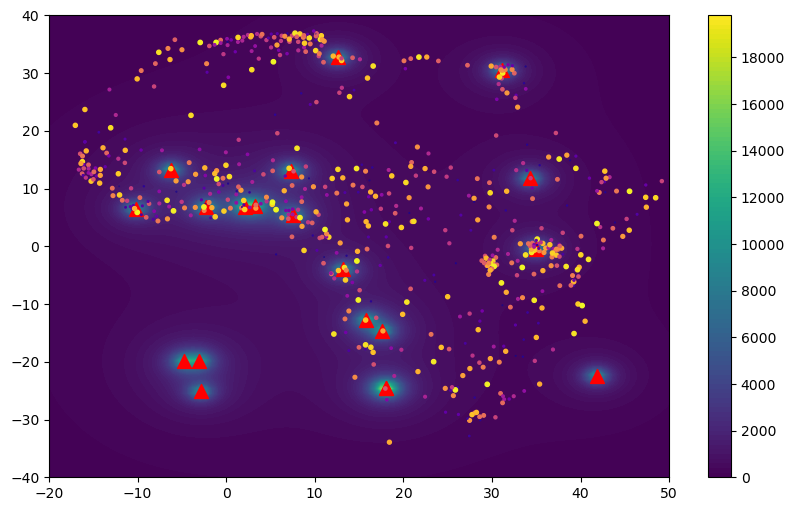

In [12]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(-20, 50, 100)
y = np.linspace(-40, 40, 100)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=100, cmap='viridis')
plt.colorbar(cf, ax = ax)
for i in range(N) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 100, label = "sattelites")
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)